# Tabular data linearization (Continued)

This example shows how to table-aware linearization in Textractor can apply various transformations on the table to improve QA performance. 

## Installation

To begin, install the `amazon-textract-textractor` package using pip.

`pip install amazon-textract-textractor`

There are various sets of dependencies available to tailor your installation to your use case. The base package will have sensible default, but you may want to install the PDF extra dependencies if your workflow uses PDFs with `pip install amazon-textract-textractor[pdf]`. You can read more on extra dependencies [in the documentation](https://aws-samples.github.io/amazon-textract-textractor/installation.html)

## Calling Textract

In [1]:
import os
from PIL import Image
from textractor import Textractor
from textractor.visualizers.entitylist import EntityList
from textractor.data.constants import TextractFeatures
from textractor.data.text_linearization_config import TextLinearizationConfig

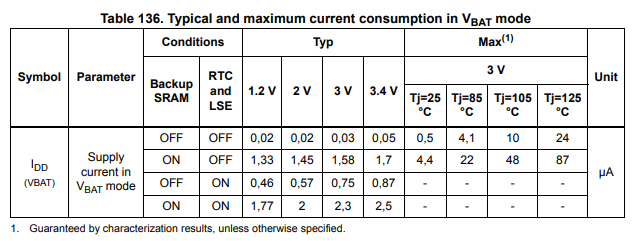

In [34]:
image = Image.open("../../../tests/fixtures/vbat.png")
image

In [35]:
extractor = Textractor(region_name="us-west-2")

document = extractor.analyze_document(
    file_source=image,
    features=[TextractFeatures.TABLES], 
    save_image=True
)

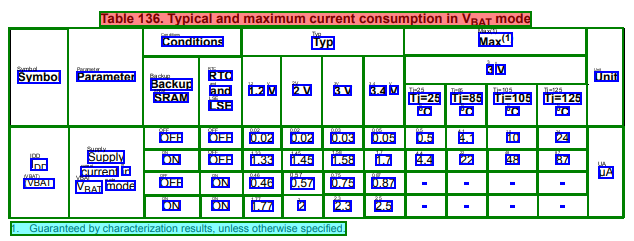

In [36]:
document.tables[0].visualize()

In [37]:
markdown_table = document.tables[0].get_text(TextLinearizationConfig(table_linearization_format='markdown'))

Let's visualize the markdown output:

| 0          | 1                           | 2           | 3           | 4     | 5    | 6    | 7     | 8        | 9        | 10        | 11        | 12   |
|------------|-----------------------------|-------------|-------------|-------|------|------|-------|----------|----------|-----------|-----------|------|
| Symbol     | Parameter                   | Conditions  |             | Typ   |      |      |       | Max(1)   |          |           |           | Unit |
|            |                             | Backup SRAM | RTC and LSE | 1.2 V | 2V   | 3V   | 3.4 V | 3 y      |          |           |           |      |
|            |                             |             |             |       |      |      |       | Tj=25 °C | Tj=85 °C | Tj=105 °C | Tj=125 °C |      |
| IDD (VBAT) | Supply current in VBAT mode | OFF         | OFF         | 0,02  | 0,02 | 0,03 | 0,05  | 0,5      | 4,1      | 10        | 24        | UA   |
|            |                             | ON          | OFF         | 1,33  | 1,45 | 1,58 | 1,7   | 4,4      | 22       | 48        | 87        |      |
|            |                             | OFF         | ON          | 0,46  | 0,57 | 0,75 | 0,87  | -        | -        | -         | -         |      |
|            |                             | ON          | ON          | 1,77  | 2    | 2,3  | 2,5   | -        | -        | -         | -         |      |

Markdown does not support merged cells. This is problematic as we see that the "Oversampling" columns end up mostly empty. Let's test Claude v2 on that table representation.

In [6]:
import json 
import boto3

def get_response_from_claude(context, prompt_data):
    body = json.dumps({
        "prompt": f"""Human: Given the following document:
        {context}
        Answer the following:\n {prompt_data}
        Assistant:""",
        "max_tokens_to_sample": 2000,
        "top_k": 1,
    })
    modelId = f'anthropic.claude-instant-v1' # change this to use a different version from the model provider
    accept = '*/*'
    contentType = 'application/json'

    response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    answer = response_body.get('completion')

    return answer

os.environ["AWS_DEFAULT_REGION"] = "us-west-2"
os.environ["BEDROCK_ENDPOINT_URL"] = "https://bedrock-runtime.us-west-2.amazonaws.com"

bedrock = boto3.client(service_name='bedrock-runtime',region_name='us-west-2',endpoint_url='https://bedrock-runtime.us-west-2.amazonaws.com')

In [51]:
question = "What is the max supply current at 125°C if both Backup SRAM and RTC and LSE are OFF? Answer in one line"

The correct answer is 24uA

In [52]:
print(get_response_from_claude(markdown_table, question))

 0.05 UA


We see that Claude using the text is unable to extract the correct answer. However we can change the `TextLinearizationConfig` to duplicate text in merged cells:

In [53]:
markdown_table_with_duplication = document.tables[0].get_text(TextLinearizationConfig(table_linearization_format='markdown', table_duplicate_text_in_merged_cells=True))

Let's visualize the markdown output:

| 0          | 1                           | 2           | 3           | 4     | 5    | 6    | 7     | 8        | 9        | 10        | 11        | 12   |
|------------|-----------------------------|-------------|-------------|-------|------|------|-------|----------|----------|-----------|-----------|------|
| Symbol     | Parameter                   | Conditions  | Conditions  | Typ   | Typ  | Typ  | Typ   | Max(1)   | Max(1)   | Max(1)    | Max(1)    | Unit |
| Symbol     | Parameter                   | Backup SRAM | RTC and LSE | 1.2 V | 2V   | 3V   | 3.4 V | 3 y      | 3 y      | 3 y       | 3 y       | Unit |
| Symbol     | Parameter                   | Backup SRAM | RTC and LSE | 1.2 V | 2V   | 3V   | 3.4 V | Tj=25 °C | Tj=85 °C | Tj=105 °C | Tj=125 °C | Unit |
| IDD (VBAT) | Supply current in VBAT mode | OFF         | OFF         | 0,02  | 0,02 | 0,03 | 0,05  | 0,5      | 4,1      | 10        | 24        | UA   |
| IDD (VBAT) | Supply current in VBAT mode | ON          | OFF         | 1,33  | 1,45 | 1,58 | 1,7   | 4,4      | 22       | 48        | 87        | UA   |
| IDD (VBAT) | Supply current in VBAT mode | OFF         | ON          | 0,46  | 0,57 | 0,75 | 0,87  | -        | -        | -         | -         | UA   |
| IDD (VBAT) | Supply current in VBAT mode | ON          | ON          | 1,77  | 2    | 2,3  | 2,5   | -        | -        | -         | -         | UA   |

In [54]:
print(get_response_from_claude(markdown_table_with_duplication, question))

 24 UA


Let's now try something different

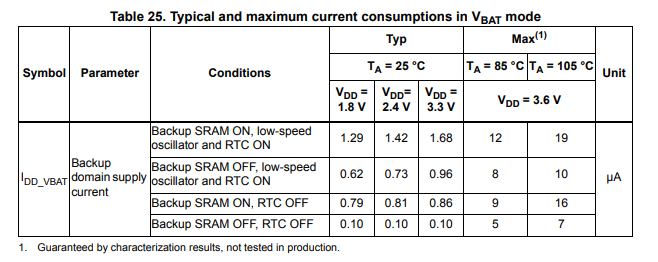

In [55]:
image = Image.open("../../../tests/fixtures/vbat2.png")
image

In [56]:
document = extractor.analyze_document(
    file_source=image,
    features=[TextractFeatures.TABLES], 
    save_image=True
)

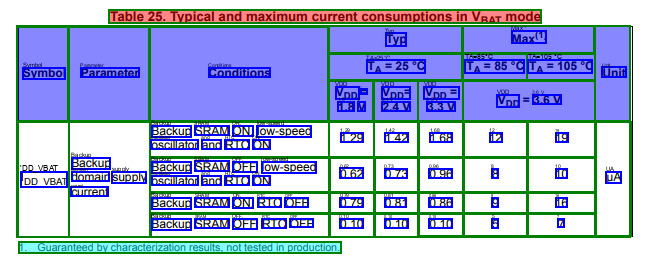

In [57]:
document.tables[0].visualize()

In [58]:
markdown_table_2 = document.tables[0].get_text(
    TextLinearizationConfig(
        table_linearization_format='markdown'
    )
)

| Symbol    | Parameter                    | Conditions                                       | Typ         |           |           | Max ¹     |           | Unit    |
|-----------|------------------------------|--------------------------------------------------|-------------|-----------|-----------|-----------|-----------|---------|
|           |                              |                                                  | TA=25°C     |           |           | TA=85°C   | TA=105 °C |         |
|           |                              |                                                  | VDD = 1.8 V | VDD 2.4 V | VDD 3.3 V | VDD 3.6 V |           |         |
| 'DD_VBAT  | Backup domain supply current | Backup SRAM ON, low-speed oscillator and RTC ON  | 1.29        | 1.42      | 1.68      | 12        | 19        | UA      |
|           |                              | Backup SRAM OFF, low-speed oscillator and RTC ON | 0.62        | 0.73      | 0.96      | 8         | 10        |         |
|           |                              | Backup SRAM ON, RTC OFF                          | 0.79        | 0.81      | 0.86      | 9         | 16        |         |
|           |                              | Backup SRAM OFF, RTC OFF                         | 0.10        | 0.10      | 0.10      | 5         | 7         |         |


In [62]:
markdown_table_flattened_headers_2 = document.tables[0].get_text(
    TextLinearizationConfig(
        table_linearization_format='markdown',
        table_flatten_headers=True
    )
)

| Symbol    | Parameter                    | Conditions                                       |   Typ TA=25°C VDD = 1.8 V  |   Typ TA=25°C VDD 2.4 V  |   Typ TA=25°C VDD 3.3 V  |   Max ¹ TA=85°C VDD 3.6 V  |   Max ¹ TA=105 °C VDD 3.6 V  | Unit    |
|-----------|------------------------------|--------------------------------------------------|----------------------------|--------------------------|--------------------------|----------------------------|------------------------------|---------|
| 'DD_VBAT  | Backup domain supply current | Backup SRAM ON, low-speed oscillator and RTC ON  |                       1.29 |                     1.42 |                     1.68 |                        12  |                          19  | UA      |
|           |                              | Backup SRAM OFF, low-speed oscillator and RTC ON |                       0.62 |                     0.73 |                     0.96 |                         8  |                          10  |         |
|           |                              | Backup SRAM ON, RTC OFF                          |                       0.79 |                     0.81 |                     0.86 |                         9  |                          16  |         |
|           |                              | Backup SRAM OFF, RTC OFF                         |                       0.1  |                     0.1  |                     0.1  |                         5  |                           7  |         |

Combining it all together

In [91]:
markdown_table_flattened_headers_duplicated_text_2 = document.tables[0].get_text(
    TextLinearizationConfig(
        table_linearization_format='markdown',
        table_flatten_headers=True,
        table_duplicate_text_in_merged_cells=True,
    )
)

| Symbol    | Parameter                    | Conditions                                       |   Typ TA=25°C VDD = 1.8 V  |   Typ TA=25°C VDD 2.4 V  |   Typ TA=25°C VDD 3.3 V  |   Max ¹ TA=85°C VDD 3.6 V  |   Max ¹ TA=105 °C VDD 3.6 V  | Unit    |
|-----------|------------------------------|--------------------------------------------------|----------------------------|--------------------------|--------------------------|----------------------------|------------------------------|---------|
| 'DD_VBAT  | Backup domain supply current | Backup SRAM ON, low-speed oscillator and RTC ON  |                       1.29 |                     1.42 |                     1.68 |                        12  |                          19  | UA      |
| 'DD_VBAT  | Backup domain supply current | Backup SRAM OFF, low-speed oscillator and RTC ON |                       0.62 |                     0.73 |                     0.96 |                         8  |                          10  | UA      |
| 'DD_VBAT  | Backup domain supply current | Backup SRAM ON, RTC OFF                          |                       0.79 |                     0.81 |                     0.86 |                         9  |                          16  | UA      |
| 'DD_VBAT  | Backup domain supply current | Backup SRAM OFF, RTC OFF                         |                       0.1  |                     0.1  |                     0.1  |                         5  |                           7  | UA      |

## Conclusion

By leveraging Textract Tables, we can build a better text representation of the tabular data, leading to a better performance in question answering tasks.